
# Project: Investigate Kaggle's Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


### Database Summary:
- +25,000 matches
- +10,000 players
- 11 European Countries with their lead championship
- Seasons 2008 to 2016
- Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
- Team line up with squad formation (X, Y coordinates)
- Betting odds from up to 10 providers
- Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches

I will be comparing the top 4 leagues in the UEFA ranking: Spain, England, Italy, and Germany

There are certain stereotypes for each league such as the Italian league being very defensive and the German league being the most competitive. The analysis will be done by comparing Match stats by each of the 4 top leagues such as Home vs Away goal differences, average goals scored per game, and the total goals scored in each season. 

### Questions to be answered: 
1) Is the Italian league the most defensive league? 
<br>2) Is the German league the most competitive league? 



<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [17]:
import numpy as np 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

conn = sqlite3.connect('database.sqlite')

countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [18]:
#Joining league table with country table to see which league goes with which country
leagues = pd.read_sql("""SELECT *
                        FROM League 
                        JOIN Country ON Country.id = League.country_id;""", conn)
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


In [23]:
#Information about the Match table where we will get most of the info we'd like to see
matches = pd.read_csv('data/Match.csv')

matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [25]:
#Luckily, it looks like the columns we are trying to investigate are not null. Since we are focusing on the
#teams and goals scored, we won't need to clean the data separately. 
matches.isnull().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
                    ...  
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD         

In [21]:
#Match details we want to look at for comparing leagues
match_details = pd.read_sql("""SELECT Match.id, 
                                        Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season, 
                                        stage, 
                                        date,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id 
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name = 'England'
                                ORDER by date
                                LIMIT 5;""", conn)
match_details

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
1,1731,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1
2,1732,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,West Ham United,Wigan Athletic,2,1
3,1734,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Everton,Blackburn Rovers,2,3
4,1735,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Middlesbrough,Tottenham Hotspur,2,1




### Data Cleaning

In [22]:
#The tables we are looking at are not missing any data so no separate cleaing/trimming will need to be done. 
#Noticed that Germany has 4 less rounds compared to other countrys' leagues. 

leages_by_season = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        count(distinct stage) AS number_of_stages,
                                        count(distinct HT.team_long_name) AS number_of_teams,
                                        avg(home_team_goal) AS avg_home_team_goals, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals, 
                                        sum(home_team_goal+away_team_goal) AS total_goals                                       
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'Italy', 'England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 30
                                ORDER BY Country.name, League.name, season DESC
                                ;""", conn)
leages_by_season

,country_name,league_name,season,number_of_stages,number_of_teams,avg_home_team_goals,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,1.492105,1.207895,0.284211,2.700000,1026
1,England,England Premier League,2014/2015,38,20,1.473684,1.092105,0.381579,2.565789,975
2,England,England Premier League,2013/2014,38,20,1.573684,1.194737,0.378947,2.768421,1052
3,England,England Premier League,2012/2013,38,20,1.557895,1.239474,0.318421,2.797368,1063
4,England,England Premier League,2011/2012,38,20,1.589474,1.215789,0.373684,2.805263,1066
5,England,England Premier League,2010/2011,38,20,1.623684,1.173684,0.450000,2.797368,1063
6,England,England Premier League,2009/2010,38,20,1.697368,1.073684,0.623684,2.771053,1053
7,England,England Premier League,2008/2009,38,20,1.400000,1.078947,0.321053,2.478947,942
8,Germany,Germany 1. Bundesliga,2015/2016,34,18,1.565359,1.264706,0.300654,2.830065,866
9,Germany,Germany 1. Bundesliga,2014/2015,34,18,1.588235,1.166667,0.421569,2.754902,843


<a id='eda'></a>
## Exploratory Data Analysis


### 1) Is the Italian league the most defensive league? 

In order to see which league is the most defensive, I will compare the average goals scored per game along with the total goals by league. 

**Since the German league plays 4 less rounds than the other 3 leagues, I will exclude Germany from the total goals comparison.**

In [5]:

goal_by_league = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        avg(home_team_goal) AS avg_home_team_goals, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals,
                                        sum(home_team_goal+away_team_goal) AS total_goals
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'Italy', 'England')
                                GROUP BY Country.name, League.name
                                ORDER BY Country.name, League.name DESC;""", conn)
goal_by_league

,country_name,league_name,avg_home_team_goals,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,1.550987,1.159539,0.391447,2.710526,8240
1,Germany,Germany 1. Bundesliga,1.626634,1.274918,0.351716,2.901552,7103
2,Italy,Italy Serie A,1.500829,1.116009,0.384819,2.616838,7895
3,Spain,Spain LIGA BBVA,1.631250,1.135855,0.495395,2.767105,8412


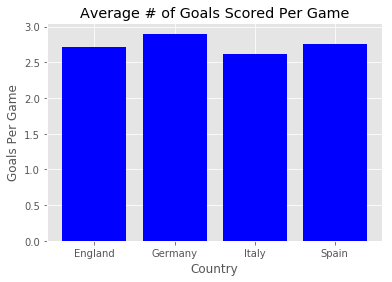

In [6]:
plt.style.use('ggplot')

x = ['England', 'Germany', 'Italy', 'Spain']
avg_goals = [2.71, 2.90, 2.61, 2.76]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, avg_goals, color='blue')
plt.xlabel("Country")
plt.ylabel("Goals Per Game")
plt.title("Average # of Goals Scored Per Game")

plt.xticks(x_pos, x)

plt.show()

#### Graph Insights

This graph shows us that Italy has the least goals per game out of the top 4 leagues in Europe, which aligns with the assumption that their league is the most defensive. 

In [7]:
#Total number of goals per season by league to compare total goal scored trends

goal_by_season = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        season,
                                        avg(home_team_goal+away_team_goal) AS avg_goals,
                                        sum(home_team_goal+away_team_goal) AS total_goals                                     
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Italy', 'Germany','England')
                                GROUP BY Country.name, League.name, season
                                HAVING count(distinct stage) > 30
                                ORDER BY Country.name, League.name, season;""", conn)

goal_by_season

,country_name,league_name,season,avg_goals,total_goals
0,England,England Premier League,2008/2009,2.478947,942
1,England,England Premier League,2009/2010,2.771053,1053
2,England,England Premier League,2010/2011,2.797368,1063
3,England,England Premier League,2011/2012,2.805263,1066
4,England,England Premier League,2012/2013,2.797368,1063
5,England,England Premier League,2013/2014,2.768421,1052
6,England,England Premier League,2014/2015,2.565789,975
7,England,England Premier League,2015/2016,2.700000,1026
8,Germany,Germany 1. Bundesliga,2008/2009,2.921569,894
9,Germany,Germany 1. Bundesliga,2009/2010,2.830065,866


Text(0,0.5,'Goals per Season')

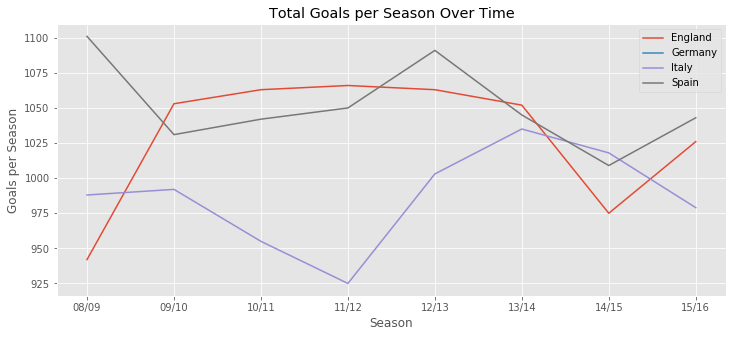

In [13]:
df = pd.DataFrame(index=np.sort(goal_by_season['season'].unique()), columns=goal_by_season['country_name'].unique())

df.loc[:,'Spain']   = list(goal_by_season.loc[goal_by_season['country_name']=='Spain','total_goals'])
df.loc[:,'Italy']   = list(goal_by_season.loc[goal_by_season['country_name']=='Italy','total_goals'])
df.loc[:,'England']   = list(goal_by_season.loc[goal_by_season['country_name']=='England','total_goals'])

df.plot(figsize=(12,5),title='Total Goals per Season Over Time')

x = [0,1,2,3,4,5,6,7]
labels = ['08/09', '09/10', '10/11', '11/12', '12/13', '13/14', '14/15', '15/16']
plt.xticks(x, labels)
plt.xlabel("Season")
plt.ylabel("Goals per Season")


#### Graph Insights
This graph shows us that Italy is consistently the league with the least overall goals except for 2 out of 8 seasons.
As mentioned, Germany was excluded from this graph as it has 4 less rounds than the other 3 leagues. 

### 2) Is the German league the most competitive league? 

In [9]:
#Comparing average number of goals scored by home and away teams per game, average # of goals scored. 
goal_by_league = pd.read_sql("""SELECT Country.name AS country_name, 
                                        League.name AS league_name, 
                                        avg(home_team_goal) AS avg_home_team_goals, 
                                        avg(away_team_goal) AS avg_away_team_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'Germany', 'Italy', 'England')
                                GROUP BY Country.name, League.name
                                ORDER BY Country.name, League.name DESC;""", conn)
goal_by_league

,country_name,league_name,avg_home_team_goals,avg_away_team_goals,avg_goal_dif,avg_goals
0,England,England Premier League,1.550987,1.159539,0.391447,2.710526
1,Germany,Germany 1. Bundesliga,1.626634,1.274918,0.351716,2.901552
2,Italy,Italy Serie A,1.500829,1.116009,0.384819,2.616838
3,Spain,Spain LIGA BBVA,1.631250,1.135855,0.495395,2.767105


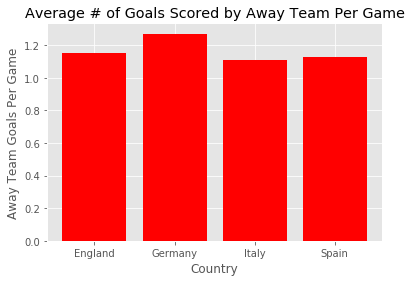

In [10]:
plt.style.use('ggplot')

x = ['England', 'Germany', 'Italy', 'Spain']
avg_goals = [1.15, 1.27, 1.11, 1.13]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, avg_goals, color='red')
plt.xlabel("Country")
plt.ylabel("Away Team Goals Per Game")
plt.title("Average # of Goals Scored by Away Team Per Game")

plt.xticks(x_pos, x)

plt.show()

#### Graph Insights
This graph shows that the German league has the highest average goals scored by Away teams in each game. This shows us that German teams have the least home advantage compared to other foreign teams. 

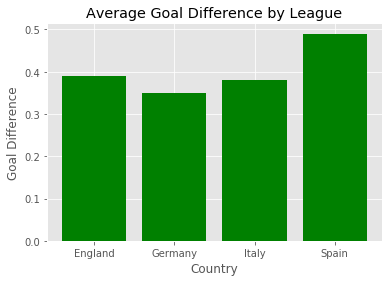

In [11]:
plt.style.use('ggplot')

x = ['England', 'Germany', 'Italy', 'Spain']
avg_goals = [0.39, 0.35, 0.38, 0.49]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, avg_goals, color='green')
plt.xlabel("Country")
plt.ylabel("Goal Difference")
plt.title("Average Goal Difference by League")

plt.xticks(x_pos, x)

plt.show()

#### Graph Insights
Matches in the German league have the lowest average goal difference. This was calculated by subtracting the Home team's goals scored by the Away team's goals scored. In the previous graphs, we learned that the German league has the most number of goals scored per match, which indicates that they have the most competitive matches. 

Text(0,0.5,'Avg Goals per Game')

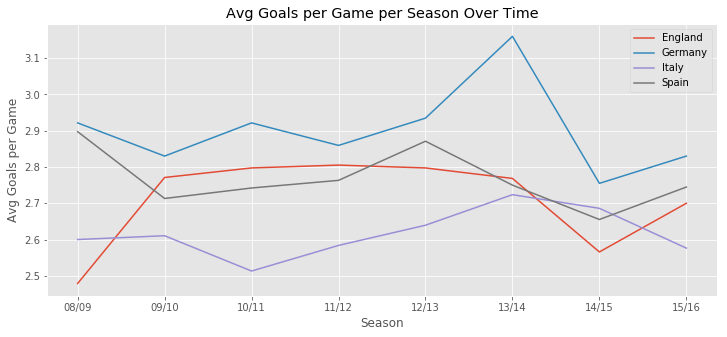

In [12]:
df = pd.DataFrame(index=np.sort(goal_by_season['season'].unique()), columns=goal_by_season['country_name'].unique())

df.loc[:,'Spain']   = list(goal_by_season.loc[goal_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'Italy']   = list(goal_by_season.loc[goal_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(goal_by_season.loc[goal_by_season['country_name']=='England','avg_goals'])
df.loc[:,'Germany']   = list(goal_by_season.loc[goal_by_season['country_name']=='Germany','avg_goals'])

df.plot(figsize=(12,5),title='Avg Goals per Game per Season Over Time')

x = [0,1,2,3,4,5,6,7]
labels = ['08/09', '09/10', '10/11', '11/12', '12/13', '13/14', '14/15', '15/16']
plt.xticks(x, labels)
plt.xlabel("Season")
plt.ylabel("Avg Goals per Game")


#### Graph Insights
The German league consistently has a significantly higher number of goals scored per game, per season. 

<a id='conclusions'></a>
## Conclusions


### 1) Is the Italian league the most defensive league? 

#### Steps of Analysis
- Aggregated Match stats for the top 4 leagues (Spain, Germany, England, Italy) and grouped them by Season.
- Compared match statistics such as average number of goals scored by Home/Away teams, average goal difference per match, average goals scored per match, and total goals of each league by season. 
- As I was checking if the Italian league was actually the most defensive league as the stereotype, I compared the average number of goals scored per game by league. 
- The analysis showed us that the Italian league indeed had the least goals scored per match over 8 seasons compared to the other 3 leagues. 
- After that, I compared the total goals scored in each league per season. The German league was excluded as it had 4 less rounds than the other 3 leagues. 
- The analysis showed that the Itian league consistently had the least amount of goals scored per season for 6 out of 8 seasons. 

#### Findings
- The average number of goals scored per game through out 8 seasons shows us that the Italian League has the least. 
- Except for the 08/09 & 14/15 season, the Italian League has the least total goals per season. 
- Such metrics can be a good indicator of overall tactics in the league. The Italian League is known for their defensive tactics and the findings align with that stereotype. 

#### Limitations
- It would give us a clearer picture if we analyzed the tactics used for each game, or the type of players fielded compared to other leagues to further prove the point. 

### 2) Is the German league the most competitive league?  

#### Steps of Analysis
- Aggregated Match stats for the top 4 leagues (Spain, Germany, England, Italy) and grouped them by Country.
- Compared match statistics such as average number of goals scored by Home/Away teams, average goal difference per match, average goals scored per match
- Just like any other sport, playing at Home or Away is a huge factor, which translates to Home Advantage. To see how that is in Germany, I compared the average number of goals scored by an Away team. 
- The analysis showed me that home teams in Germany get scored on the most by the visiting team, meaning that the German teams have the least home advantage. 
- After that, I aggregated the average goals scored per game and grouped them by season to see the trend compared to other leagues.
- The analysis showed me that the German league consistently has a significantly higher number of goals scored per game, per season.

#### Findings
- The average number of goals scored by away teams per game shows us that the German League has the highest. This can mean that Home Advantage is least affective in Germany compared to other leagues. 
- The German League consistently has the most goals per game through out all 8 seasons. They also have the lowest average goal difference per game, confirming the assumption that Home Advantage is the least affective in Germany. 

#### Limitations
- It would be very interesting to see the league table for each season to compare the gaps between top and bottom teams. This analysis only goes over the data by league and season so can't learn anything about the team performances each year. 